In [1]:
import statistics
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

import pyxdf
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats


import os

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

from tqdm import tqdm_notebook

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_val_score,cross_validate 

In [10]:
#создадим словари с ЭЭГ и с событиями по всем людям
path_dir = "C:\\Users\\Lenovo\\1easyEEG\\eeg_raw"

dir_list = os.listdir(path_dir)
dir_list.remove('events')

raw_list = {}
names=[]
for i in dir_list:
    name = i[:9]
    names.append(name)
    raw = mne.io.read_raw_fif(path_dir+'\\'+i, preload=True)
    #events = np.load(path_dir_eve+'\\'+i)
    #raw = fileLoad(path_dir+'\\'+i)
    #raw.pick(['all']).load_data()
    raw_list[name] = raw
    #events_list[name] = events
    text = '\n'+ name + "succesful" + '\n'
    print(text)

Opening raw data file C:\Users\Lenovo\1easyEEG\eeg_raw\Alice_neuroplay_raw.fif...
    Range : 0 ... 37082 =      0.000 ...   296.982 secs
Ready.
Reading 0 ... 37082  =      0.000 ...   296.982 secs...

Alice_neusuccesful

Opening raw data file C:\Users\Lenovo\1easyEEG\eeg_raw\Alice_nvx_raw.fif...
    Range : 0 ... 171999 =      0.000 ...   343.998 secs
Ready.
Reading 0 ... 171999  =      0.000 ...   343.998 secs...

Alice_nvxsuccesful

Opening raw data file C:\Users\Lenovo\1easyEEG\eeg_raw\Almaz_muse_raw.fif...
    Range : 0 ... 75407 =      0.000 ...   294.523 secs
Ready.
Reading 0 ... 75407  =      0.000 ...   294.523 secs...

Almaz_mussuccesful

Opening raw data file C:\Users\Lenovo\1easyEEG\eeg_raw\Almaz_neuroplay_raw.fif...
    Range : 0 ... 42617 =      0.000 ...   341.468 secs
Ready.
Reading 0 ... 42617  =      0.000 ...   341.468 secs...

Almaz_neusuccesful

Opening raw data file C:\Users\Lenovo\1easyEEG\eeg_raw\Almaz_nvx_raw.fif...
    Range : 0 ... 150999 =      0.000 ...   3

Ready.
Reading 0 ... 77075  =      0.000 ...   301.046 secs...

SonyN_mussuccesful

Opening raw data file C:\Users\Lenovo\1easyEEG\eeg_raw\SonyN_neuroplay_raw.fif...
    Range : 0 ... 37940 =      0.000 ...   303.982 secs
Ready.
Reading 0 ... 37940  =      0.000 ...   303.982 secs...

SonyN_neusuccesful

Opening raw data file C:\Users\Lenovo\1easyEEG\eeg_raw\SonyN_nvx_raw.fif...
    Range : 0 ... 147999 =      0.000 ...   295.998 secs
Ready.
Reading 0 ... 147999  =      0.000 ...   295.998 secs...

SonyN_nvxsuccesful



In [11]:

path_dir_eve = "C:\\Users\\Lenovo\\1easyEEG\\eeg_raw\\events"
dir_list_eve = os.listdir(path_dir_eve)

#dir_list.remove('desktop.ini')
events_list = {}
#names=[]
for i in dir_list_eve:
    name = i[:9]
    events = np.load(path_dir_eve+'\\'+i)
    events_list[name] = events
    text = '\n'+ name + "succesful" + '\n'
    print(text)


Alice_neusuccesful


Alice_nvxsuccesful


Almaz_mussuccesful


Almaz_neusuccesful


Almaz_nvxsuccesful


Balts_mussuccesful


Balts_neusuccesful


Balts_nvxsuccesful


Dolgi_mussuccesful


Dolgi_neusuccesful


Dolgi_nvxsuccesful


Katya_mussuccesful


Katya_neusuccesful


Katya_nvxsuccesful


Koblo_mussuccesful


Koblo_neusuccesful


Koblo_nvxsuccesful


Kurki_mussuccesful


Kurki_neusuccesful


Kurki_nvxsuccesful


Medve_mussuccesful


Medve_nvxsuccesful


Misha_mussuccesful


Misha_neusuccesful


Misha_nvxsuccesful


Mozgo_mussuccesful


Mozgo_neusuccesful


Mozgo_nvxsuccesful


Nasty_mussuccesful


Nasty_neusuccesful


Nasty_nvxsuccesful


Pilug_mussuccesful


Pilug_neusuccesful


Pilug_nvxsuccesful


Sasha_mussuccesful


Sasha_neusuccesful


Sasha_nvxsuccesful


SonyN_mussuccesful


SonyN_neusuccesful


SonyN_nvxsuccesful



т е мы создали raw_list и events_list - словари с ээг и событиями по всем людям

In [4]:
raw_list

{'Alice_neu': <Raw | Alice_neuroplay_raw.fif, 6 x 37083 (297.0 s), ~1.7 MB, data loaded>,
 'Alice_nvx': <Raw | Alice_nvx_raw.fif, 10 x 172000 (344.0 s), ~13.1 MB, data loaded>,
 'Almaz_mus': <Raw | Almaz_muse_raw.fif, 5 x 75408 (294.5 s), ~2.9 MB, data loaded>,
 'Almaz_neu': <Raw | Almaz_neuroplay_raw.fif, 6 x 42618 (341.5 s), ~2.0 MB, data loaded>,
 'Almaz_nvx': <Raw | Almaz_nvx_raw.fif, 10 x 151000 (302.0 s), ~11.5 MB, data loaded>,
 'Balts_mus': <Raw | Balts_muse_raw.fif, 5 x 84972 (333.5 s), ~3.3 MB, data loaded>,
 'Balts_neu': <Raw | Balts_neuroplay_raw.fif, 6 x 37605 (301.0 s), ~1.7 MB, data loaded>,
 'Balts_nvx': <Raw | Balts_nvx_raw.fif, 10 x 148000 (296.0 s), ~11.3 MB, data loaded>,
 'Dolgi_mus': <Raw | Dolgi_muse_raw.fif, 5 x 78612 (307.0 s), ~3.0 MB, data loaded>,
 'Dolgi_neu': <Raw | Dolgi_neuroplay_raw.fif, 6 x 39264 (314.5 s), ~1.8 MB, data loaded>,
 'Dolgi_nvx': <Raw | Dolgi_nvx_raw.fif, 10 x 175000 (350.0 s), ~13.4 MB, data loaded>,
 'Katya_mus': <Raw | Katya_muse_raw.f

In [12]:
fiveletters = []
for i in names:
    fiveletters.append(i[:5])
fiveletters = set(fiveletters)
fiveletters = list(fiveletters)
fiveletters

['Alice',
 'Kurki',
 'Mozgo',
 'Dolgi',
 'Misha',
 'Balts',
 'Sasha',
 'Nasty',
 'Medve',
 'Almaz',
 'Pilug',
 'Katya',
 'SonyN',
 'Koblo']

In [13]:
dict5l = {}
for i in fiveletters:
    dict5l[i] = {}

In [7]:
dict5l

{'Alice': {},
 'Kurki': {},
 'Mozgo': {},
 'Dolgi': {},
 'Misha': {},
 'Balts': {},
 'Sasha': {},
 'Nasty': {},
 'Medve': {},
 'Almaz': {},
 'Pilug': {},
 'Katya': {},
 'SonyN': {},
 'Koblo': {}}

Sasha = {}
Pilug = {}
Misha = {}
Katya = {}
Alice = {}
Almaz = {}
SonyN = {}
Balts = {}
Koblo = {}
Dolgi = {}
Medve = {}
Mozgo = {}
Nasty = {}
Kurki = {}
dict5l = {'Sasha': {}, Pilug, Misha, Katya, Alice, Almaz, SonyN, Balts, Koblo, Dolgi, Medve, Mozgo, Nasty, Kurki}

In [14]:
names_nvx = []
names_neu = []
names_mus = []
for i in names:
    if i[-3:] == 'nvx':
        names_nvx.append(i)
    if i[-3:] == 'neu':
        names_neu.append(i)
    if i[-3:] == 'mus':
        names_mus.append(i)
    

In [16]:
%matplotlib inline
import math

In [17]:
#присоедиим нейроплей
for i in names_neu:
#psd = {}
    #ec
    print('\n')
    print(i)
    raw = raw_list[i]
    events = events_list[i]
    if events[5][2] == 4:
        ect1 = events[5][0] / raw.info['sfreq']
        ect2 = events[6][0] / raw.info['sfreq']
        print(ect1,ect2)
        raw_ec = raw.copy().crop(tmin=ect1, tmax=ect2)
        psd_ec = raw_ec.compute_psd(picks=['O1'],fmin=0, fmax=60)
        psd_ec = psd_ec.get_data(return_freqs=True)
    yy_ec = psd_ec[0][0]
    x_ec = psd_ec[1]
    y_ec = []
    for j in range(len(yy_ec)):
        if x_ec[j] == 0:
            x_ec[j] = 0.1
        n = (yy_ec[j] ** 2) / x_ec[j]
        n = math.log(n,10)
        y_ec.append(n)
    i_short = i[:5]
    dict5l[i_short][i+'_ec'] = [x_ec,y_ec]
    #plt.figure()
    #plt.plot(x_ec,y_ec)
    
    #eo
    if events[3][2] == 3:
        eot1 = events[3][0] / raw.info['sfreq']
        eot2 = events[4][0] / raw.info['sfreq']
        print(eot1,eot2)
        raw_eo = raw.copy().crop(tmin=eot1, tmax=eot2)
        psd_eo = raw_eo.compute_psd(picks=['O1'],fmin=0, fmax=60)
        psd_eo = psd_eo.get_data(return_freqs=True)
    yy_eo = psd_eo[0][0]
    x_eo = psd_eo[1]
    y_eo = []
    for j in range(len(yy_eo)):
        if x_eo[j] == 0:
            x_eo[j] = 0.1
        n = (yy_eo[j] ** 2) / x_eo[j]
        n = math.log(n,10)
        y_eo.append(n)
    dict5l[i_short][i+'_eo'] = [x_eo,y_eo]
    #plt.plot(x_eo,y_eo)
    
    #1back
    if (events[7][2] == 5) and (events[26][2] == 5):
        e1t1 = events[7][0] / raw.info['sfreq']
        e1t2 = events[26][0] / raw.info['sfreq']
        print(e1t1,e1t2)
        raw_e1 = raw.copy().crop(tmin=e1t1, tmax=e1t2)
        psd_e1 = raw_e1.compute_psd(picks=['O1'],fmin=0, fmax=60)
        psd_e1 = psd_e1.get_data(return_freqs=True)
    #for 1 back
    yy_e1 = psd_e1[0][0]
    x_e1 = psd_e1[1]
    y_e1 = []
    for j in range(len(yy_e1)):
        if x_e1[j] == 0:
            x_e1[j] = 0.1
        n = (yy_e1[j] ** 2) / x_e1[j]
        n = math.log(n,10)
        y_e1.append(n)
    dict5l[i_short][i+'_1b'] = [x_e1,y_e1]
    #plt.plot(x_e1,y_e1)
    
    #2b
    if (events[27][2] == 6) and (events[46][2] == 6):
        e2t1 = events[27][0] / raw.info['sfreq']
        e2t2 = events[46][0] / raw.info['sfreq']
        print(e2t1,e2t2)
        raw_e2 = raw.copy().crop(tmin=e2t1, tmax=e2t2)
        psd_e2 = raw_e2.compute_psd(picks=['O1'],fmin=0, fmax=60)
        psd_e2 = psd_e2.get_data(return_freqs=True)
    #for 1 back
    yy_e2 = psd_e2[0][0]
    x_e2 = psd_e2[1]
    y_e2 = []
    for j in range(len(yy_e2)):
        if x_e2[j] == 0:
            x_e2[j] = 0.1
        n = (yy_e2[j] ** 2) / x_e2[j]
        n = math.log(n,10)
        y_e2.append(n)
    dict5l[i_short][i+'_2b'] = [x_e2,y_e2]
    #plt.plot(x_e1,y_e1)
    



Alice_neu
99.25278793736446 160.03941429454966
Effective window size : 2.050 (s)
35.75118577845517 95.74494309619882
Effective window size : 2.050 (s)
165.0128655419557 222.17151538533264
Effective window size : 2.050 (s)
226.59236093858246 288.1238036661521
Effective window size : 2.050 (s)


Almaz_neu
124.87467461786434 185.85774478254612
Effective window size : 2.051 (s)
59.22833460219783 119.22586835507356
Effective window size : 2.051 (s)
200.90520316768243 257.0567411671687
Effective window size : 2.051 (s)
265.90253139996446 325.0827910552449
Effective window size : 2.051 (s)


Balts_neu
91.380102502655 152.31617716154582
Effective window size : 2.049 (s)
27.226756762483127 87.29848993685066
Effective window size : 2.049 (s)
163.38455006057995 217.06976004374775
Effective window size : 2.049 (s)
222.3038279222498 282.3275421252549
Effective window size : 2.049 (s)


Dolgi_neu
105.41357752723245 166.39822757603937
Effective window size : 2.050 (s)
38.4217712482436 98.3731904254

In [22]:
#присоедиим muse
for i in names_mus:
#psd = {}
    #ec
    print('\n')
    print(i)
    raw = raw_list[i]
    events = events_list[i]
    if events[5][2] == 4:
        ect1 = events[5][0] / raw.info['sfreq']
        ect2 = events[6][0] / raw.info['sfreq']
        print(ect1,ect2)
        raw_ec = raw.copy().crop(tmin=ect1, tmax=ect2)
        psd_ec = raw_ec.compute_psd(picks=['TP9'],fmin=0, fmax=60)
        psd_ec = psd_ec.get_data(return_freqs=True)
    yy_ec = psd_ec[0][0]
    x_ec = psd_ec[1]
    y_ec = []
    for j in range(len(yy_ec)):
        if x_ec[j] == 0:
            x_ec[j] = 0.1
        n = (yy_ec[j] ** 2) / x_ec[j]
        n = math.log(n,10)
        y_ec.append(n)
    i_short = i[:5]
    dict5l[i_short][i+'_ec'] = [x_ec,y_ec]
    #plt.figure()
    #plt.plot(x_ec,y_ec)
    
    #eo
    if events[3][2] == 3:
        eot1 = events[3][0] / raw.info['sfreq']
        eot2 = events[4][0] / raw.info['sfreq']
        print(eot1,eot2)
        raw_eo = raw.copy().crop(tmin=eot1, tmax=eot2)
        psd_eo = raw_eo.compute_psd(picks=['TP9'],fmin=0, fmax=60)
        psd_eo = psd_eo.get_data(return_freqs=True)
    yy_eo = psd_eo[0][0]
    x_eo = psd_eo[1]
    y_eo = []
    for j in range(len(yy_eo)):
        if x_eo[j] == 0:
            x_eo[j] = 0.1
        n = (yy_eo[j] ** 2) / x_eo[j]
        n = math.log(n,10)
        y_eo.append(n)
    dict5l[i_short][i+'_eo'] = [x_eo,y_eo]
    #plt.plot(x_eo,y_eo)
    
    #1back
    if (events[7][2] == 5) and (events[26][2] == 5):
        e1t1 = events[7][0] / raw.info['sfreq']
        e1t2 = events[26][0] / raw.info['sfreq']
        print(e1t1,e1t2)
        raw_e1 = raw.copy().crop(tmin=e1t1, tmax=e1t2)
        psd_e1 = raw_e1.compute_psd(picks=['TP9'],fmin=0, fmax=60)
        psd_e1 = psd_e1.get_data(return_freqs=True)
    #for 1 back
    yy_e1 = psd_e1[0][0]
    x_e1 = psd_e1[1]
    y_e1 = []
    for j in range(len(yy_e1)):
        if x_e1[j] == 0:
            x_e1[j] = 0.1
        n = (yy_e1[j] ** 2) / x_e1[j]
        n = math.log(n,10)
        y_e1.append(n)
    dict5l[i_short][i+'_1b'] = [x_e1,y_e1]
    #plt.plot(x_e1,y_e1)
    
    #2b
    if (events[27][2] == 6) and (events[46][2] == 6):
        e2t1 = events[27][0] / raw.info['sfreq']
        e2t2 = events[46][0] / raw.info['sfreq']
        print(e2t1,e2t2)
        raw_e2 = raw.copy().crop(tmin=e2t1, tmax=e2t2)
        psd_e2 = raw_e2.compute_psd(picks=['TP9'],fmin=0, fmax=60)
        psd_e2 = psd_e2.get_data(return_freqs=True)
    #for 1 back
    yy_e2 = psd_e2[0][0]
    x_e2 = psd_e2[1]
    y_e2 = []
    for j in range(len(yy_e2)):
        if x_e2[j] == 0:
            x_e2[j] = 0.1
        n = (yy_e2[j] ** 2) / x_e2[j]
        n = math.log(n,10)
        y_e2.append(n)
    dict5l[i_short][i+'_2b'] = [x_e2,y_e2]
    #plt.plot(x_e1,y_e1)
    



Almaz_mus
90.87168726649014 151.85640853267157
Effective window size : 1.000 (s)
25.043808938052727 85.05989879178296
Effective window size : 1.000 (s)
158.81649392375235 215.18459289349298
Effective window size : 1.000 (s)
220.32458861440338 280.4773804819876
Effective window size : 1.000 (s)


Balts_mus
111.52022835135479 172.48859701503977
Effective window size : 1.005 (s)
41.8348037586081 101.83766330092922
Effective window size : 1.005 (s)
185.5190453196255 245.64749954440043
Effective window size : 1.005 (s)
252.75537360452233 319.5324963316973
Effective window size : 1.005 (s)


Dolgi_mus
89.13066833455532 150.09240573552842
Effective window size : 1.000 (s)
21.166727528076496 81.18338226082182
Effective window size : 1.000 (s)
164.39752066824875 221.4070941839057
Effective window size : 1.000 (s)
230.77200425998086 291.7962264654649
Effective window size : 1.000 (s)


Katya_mus
94.77810602925274 155.76575686546755
Effective window size : 1.000 (s)
27.6854405742981 87.67707175

In [24]:
#nvx
for i in names_nvx:
    #ec
    print('\n')
    print(i)
    raw = raw_list[i]
    events = events_list[i]
    if events[5][2] == 5:
        ect1 = events[5][0] / raw.info['sfreq']
        ect2 = events[6][0] / raw.info['sfreq']
        print(ect1,ect2)
        raw_ec = raw.copy().crop(tmin=ect1, tmax=ect2)
        psd_ec = raw_ec.compute_psd(picks=['O1'],fmin=0, fmax=60)
        psd_ec = psd_ec.get_data(return_freqs=True)
    yy_ec = psd_ec[0][0]
    x_ec = psd_ec[1]
    y_ec = []
    for j in range(len(yy_ec)):
        if x_ec[j] == 0:
            x_ec[j] = 0.1
        n = (yy_ec[j] ** 2) / x_ec[j]
        n = math.log(n,10)
        y_ec.append(n)
    i_short = i[:5]
    dict5l[i_short][i+'_ec'] = [x_ec,y_ec]
    #plt.figure()
    #plt.plot(x_ec,y_ec)
    
    #eo
    if events[3][2] == 3:
        eot1 = events[3][0] / raw.info['sfreq']
        eot2 = events[4][0] / raw.info['sfreq']
        print(eot1,eot2)
        raw_eo = raw.copy().crop(tmin=eot1, tmax=eot2)
        psd_eo = raw_eo.compute_psd(picks=['O1'],fmin=0, fmax=60)
        psd_eo = psd_eo.get_data(return_freqs=True)
    yy_eo = psd_eo[0][0]
    x_eo = psd_eo[1]
    y_eo = []
    for j in range(len(yy_eo)):
        if x_eo[j] == 0:
            x_eo[j] = 0.1
        n = (yy_eo[j] ** 2) / x_eo[j]
        n = math.log(n,10)
        y_eo.append(n)
    dict5l[i_short][i+'_eo'] = [x_eo,y_eo]
    #plt.plot(x_eo,y_eo)
    
    #1back
    if (events[7][2] == 7) and (events[26][2] == 7):
        e1t1 = events[7][0] / raw.info['sfreq']
        e1t2 = events[26][0] / raw.info['sfreq']
        print(e1t1,e1t2)
        raw_e1 = raw.copy().crop(tmin=e1t1, tmax=e1t2)
        psd_e1 = raw_e1.compute_psd(picks=['O1'],fmin=0, fmax=60)
        psd_e1 = psd_e1.get_data(return_freqs=True)
    #for 1 back
    yy_e1 = psd_e1[0][0]
    x_e1 = psd_e1[1]
    y_e1 = []
    for j in range(len(yy_e1)):
        if x_e1[j] == 0:
            x_e1[j] = 0.1
        n = (yy_e1[j] ** 2) / x_e1[j]
        n = math.log(n,10)
        y_e1.append(n)
    dict5l[i_short][i+'_1b'] = [x_e1,y_e1]
    #plt.plot(x_e1,y_e1)
    
    #2b
    if (events[27][2] == 10) and (events[46][2] == 10):
        e2t1 = events[27][0] / raw.info['sfreq']
        e2t2 = events[46][0] / raw.info['sfreq']
        print(e2t1,e2t2)
        raw_e2 = raw.copy().crop(tmin=e2t1, tmax=e2t2)
        psd_e2 = raw_e2.compute_psd(picks=['O1'],fmin=0, fmax=60)
        psd_e2 = psd_e2.get_data(return_freqs=True)
    #for 1 back
    yy_e2 = psd_e2[0][0]
    x_e2 = psd_e2[1]
    y_e2 = []
    for j in range(len(yy_e2)):
        if x_e2[j] == 0:
            x_e2[j] = 0.1
        n = (yy_e2[j] ** 2) / x_e2[j]
        n = math.log(n,10)
        y_e2.append(n)
    dict5l[i_short][i+'_2b'] = [x_e2,y_e2]
    #plt.plot(x_e1,y_e1)
    



Alice_nvx
127.962 188.952
Effective window size : 0.512 (s)
64.88 124.898
Effective window size : 0.512 (s)
206.198 260.038
Effective window size : 0.512 (s)
265.39 330.262
Effective window size : 0.512 (s)


Almaz_nvx
94.536 155.532
Effective window size : 0.512 (s)
30.99 90.984
Effective window size : 0.512 (s)
164.81 220.614
Effective window size : 0.512 (s)
227.67 285.66
Effective window size : 0.512 (s)


Balts_nvx
96.102 157.11
Effective window size : 0.512 (s)
32.184 92.15
Effective window size : 0.512 (s)
166.28 221.254
Effective window size : 0.512 (s)
226.224 281.548
Effective window size : 0.512 (s)


Dolgi_nvx
96.604 157.56
Effective window size : 0.512 (s)
25.692 85.702
Effective window size : 0.512 (s)
176.152 233.342
Effective window size : 0.512 (s)
245.062 304.59
Effective window size : 0.512 (s)


Katya_nvx
103.342 164.298
Effective window size : 0.512 (s)
39.438 99.46
Effective window size : 0.512 (s)
171.16 225.498
Effective window size : 0.512 (s)
234.048 297.176

In [29]:
dict5l['SonyN']

{'SonyN_neu_ec': [array([ 0.1       ,  0.48753875,  0.97507751,  1.46261626,  1.95015502,
          2.43769377,  2.92523253,  3.41277128,  3.90031004,  4.38784879,
          4.87538755,  5.3629263 ,  5.85046506,  6.33800381,  6.82554257,
          7.31308132,  7.80062008,  8.28815883,  8.77569759,  9.26323634,
          9.7507751 , 10.23831385, 10.72585261, 11.21339136, 11.70093012,
         12.18846887, 12.67600763, 13.16354638, 13.65108514, 14.13862389,
         14.62616265, 15.1137014 , 15.60124016, 16.08877891, 16.57631767,
         17.06385642, 17.55139518, 18.03893393, 18.52647269, 19.01401144,
         19.5015502 , 19.98908895, 20.47662771, 20.96416646, 21.45170522,
         21.93924397, 22.42678273, 22.91432148, 23.40186024, 23.88939899,
         24.37693775, 24.8644765 , 25.35201526, 25.83955401, 26.32709277,
         26.81463152, 27.30217028, 27.78970903, 28.27724779, 28.76478654,
         29.2523253 , 29.73986405, 30.22740281, 30.71494156, 31.20248032,
         31.69001907, 

In [31]:
%matplotlib inline

In [ ]:
C:\\Users\\Lenovo\\1easyEEG\\psdEveryPersonEveryCondition\\

In [37]:
pwd

'C:\\Users\\Lenovo\\1easyEEG'

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8020\3913476392.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


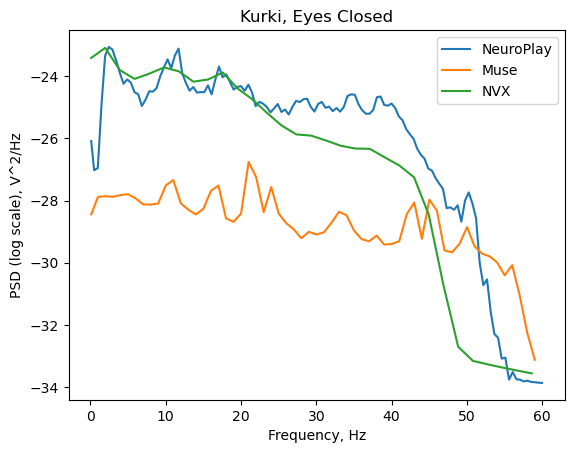

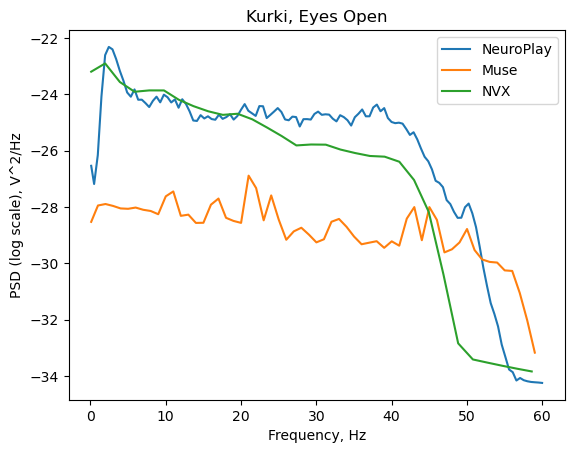

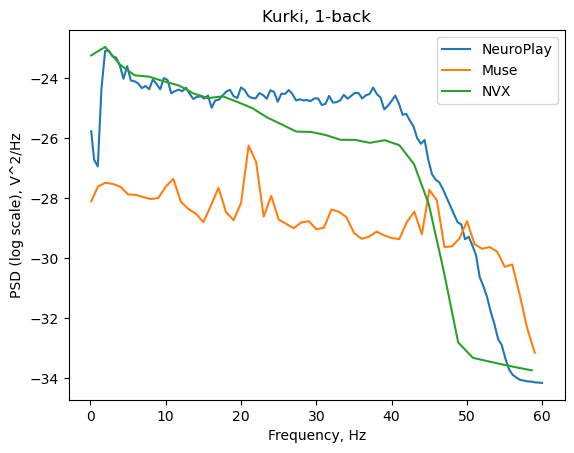

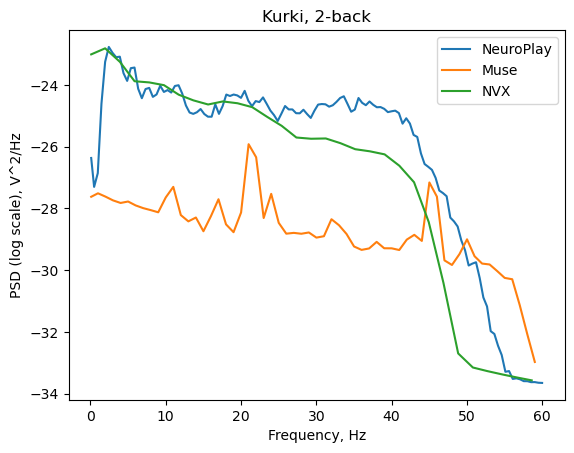

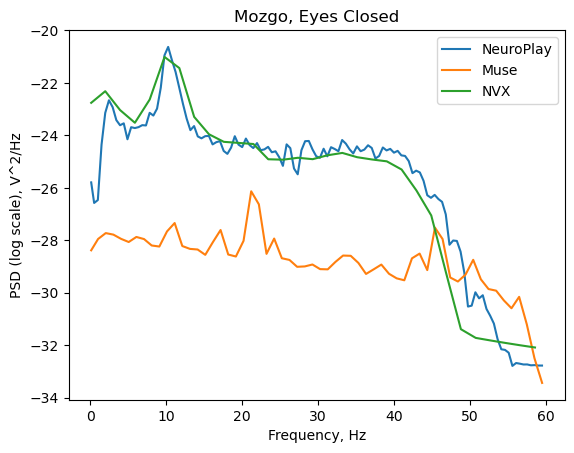

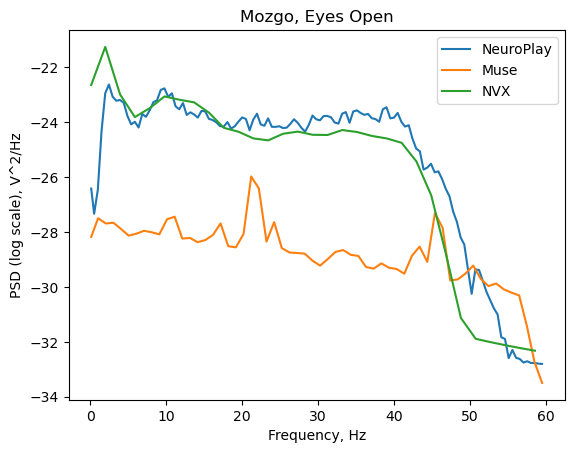

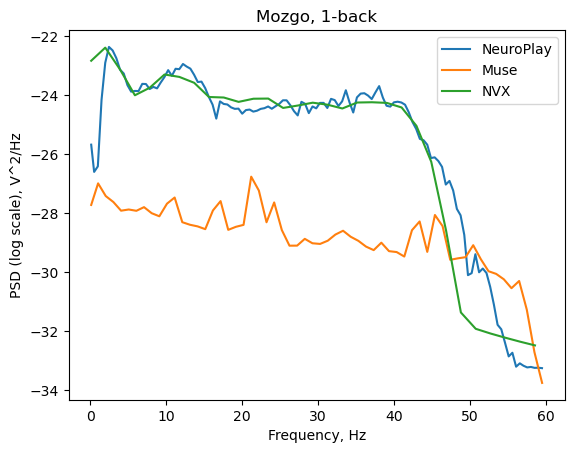

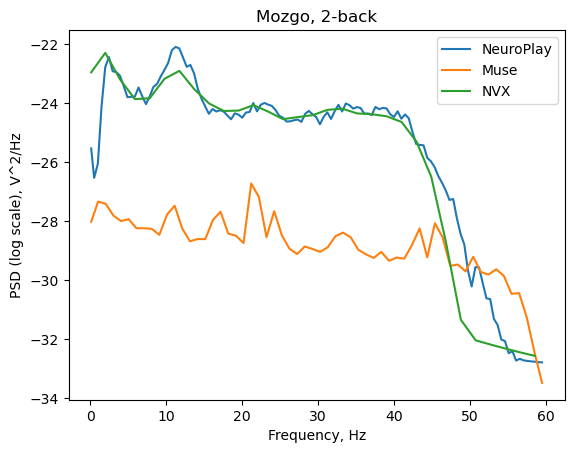

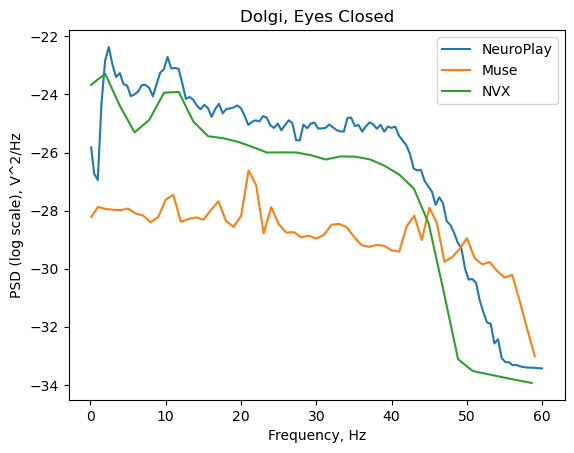

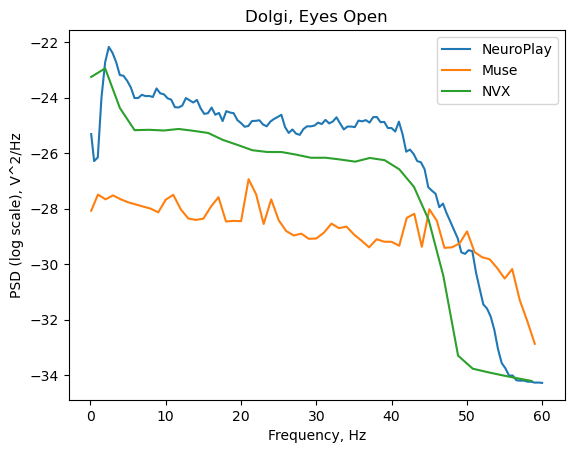

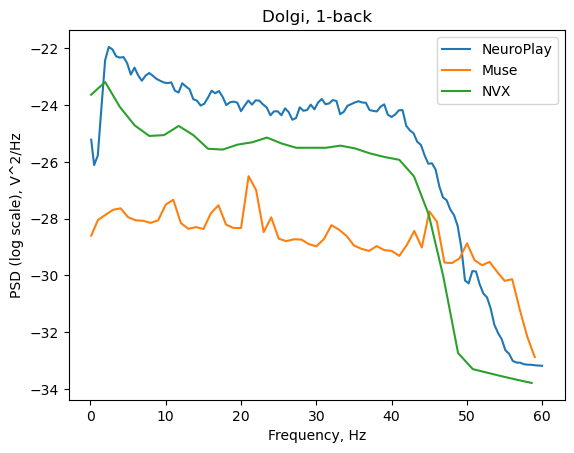

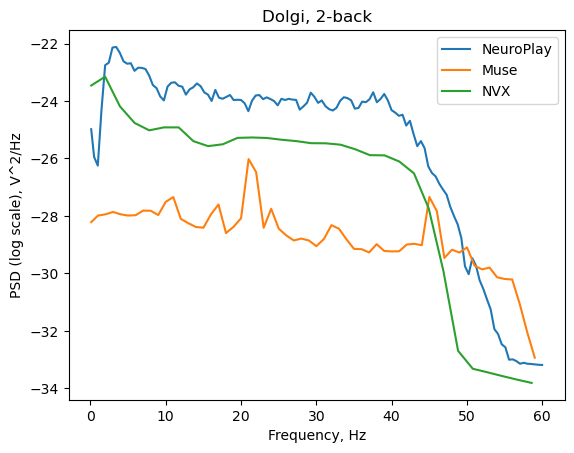

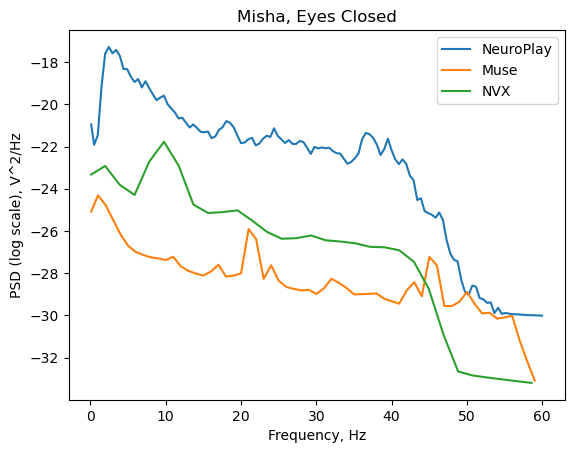

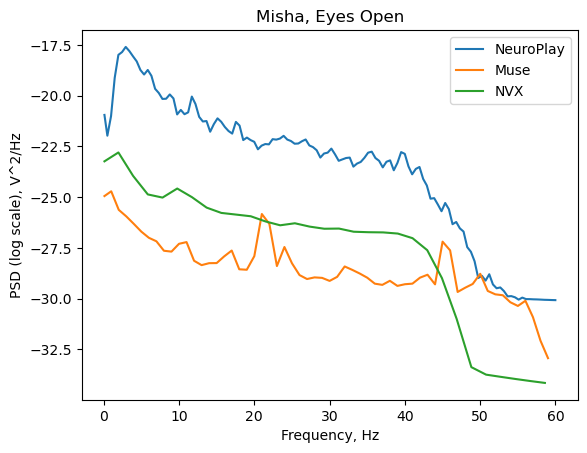

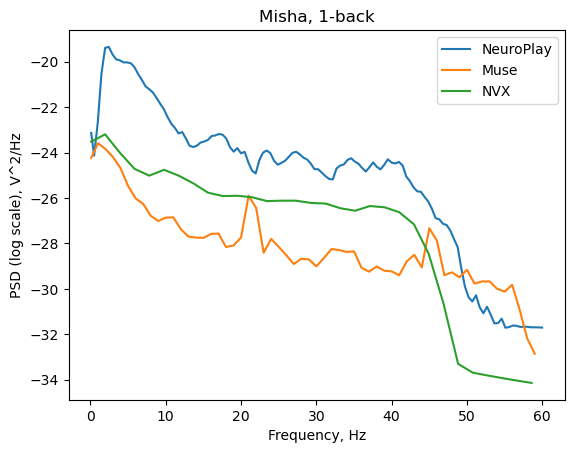

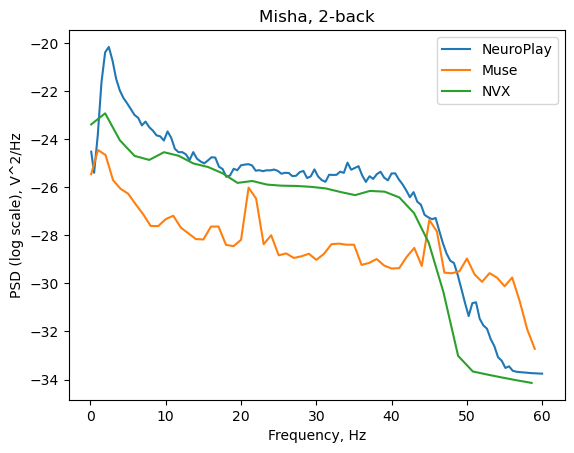

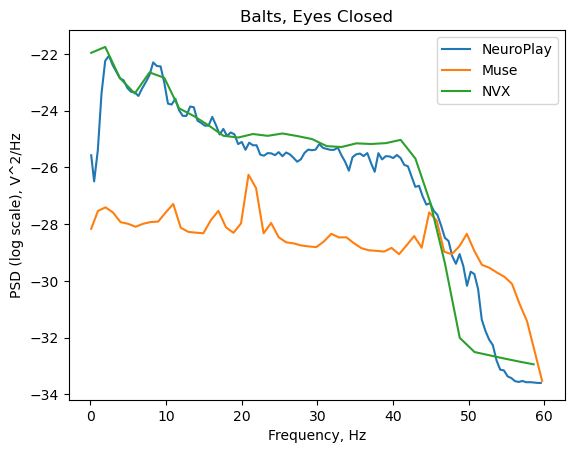

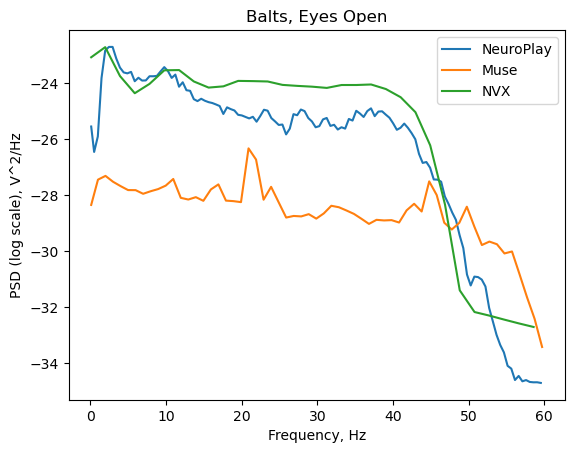

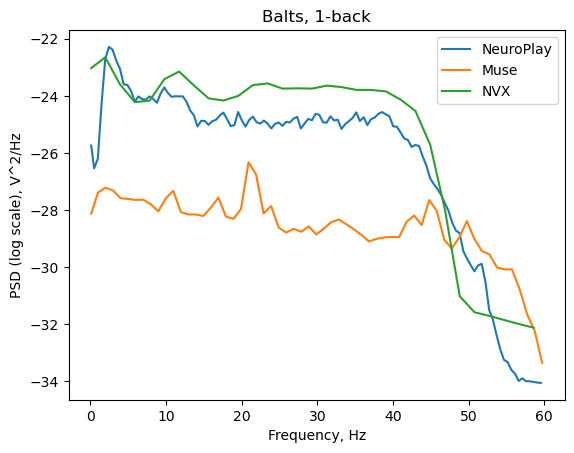

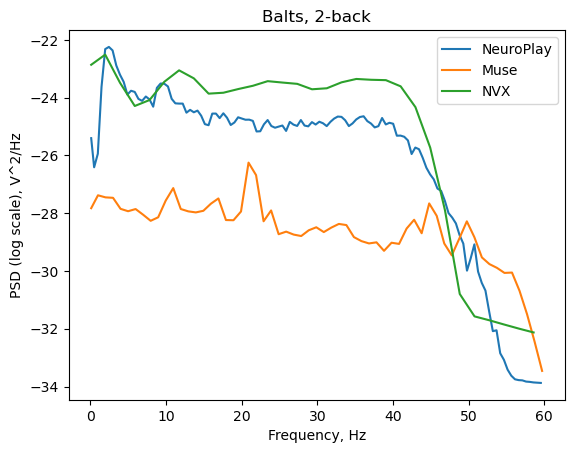

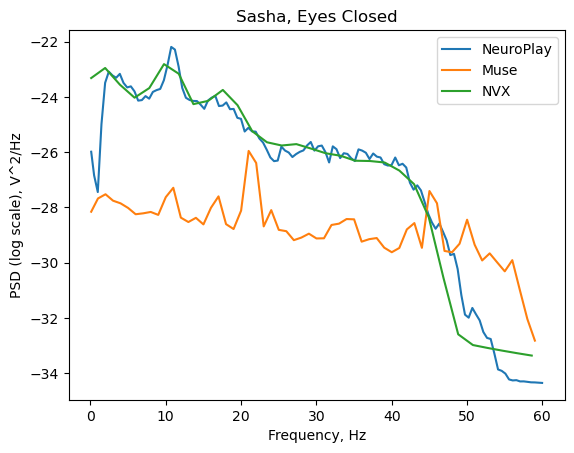

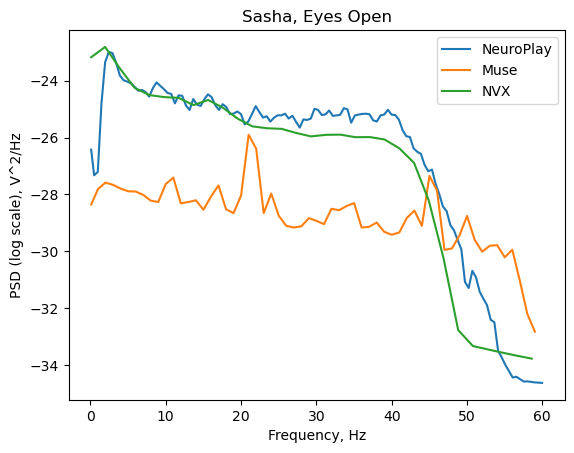

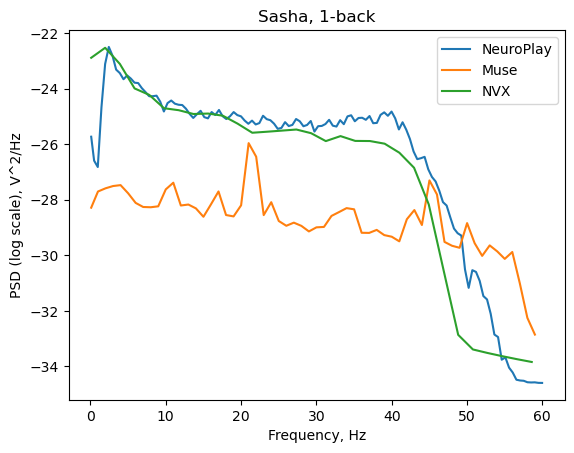

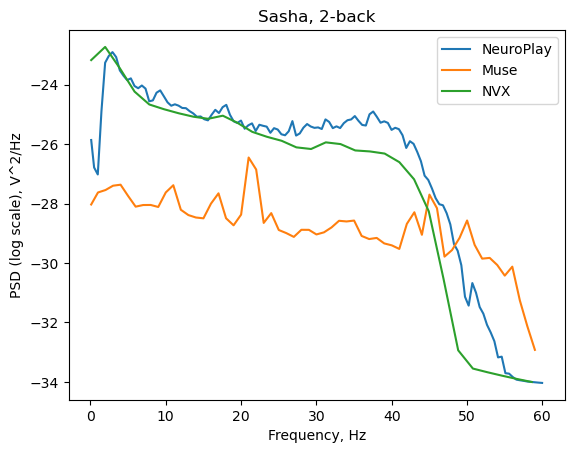

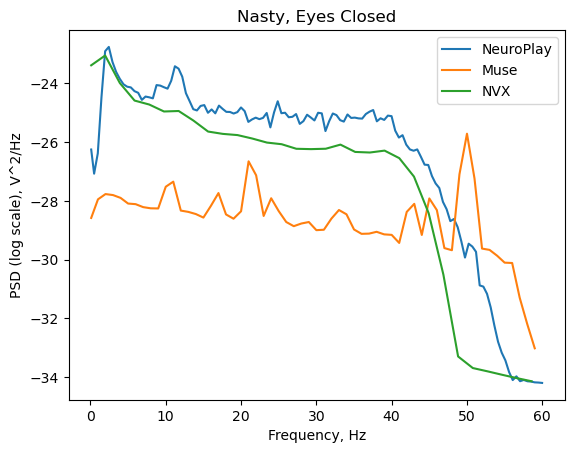

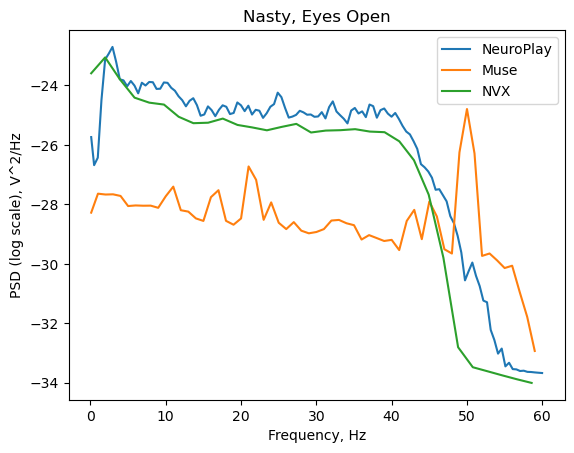

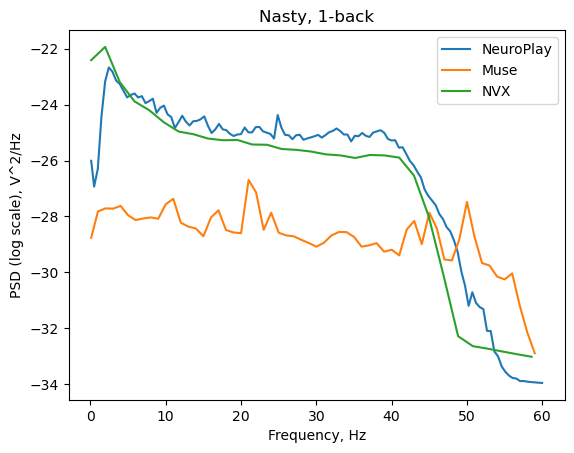

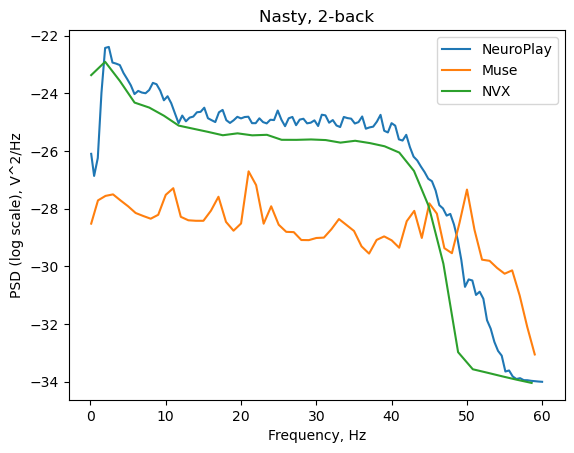

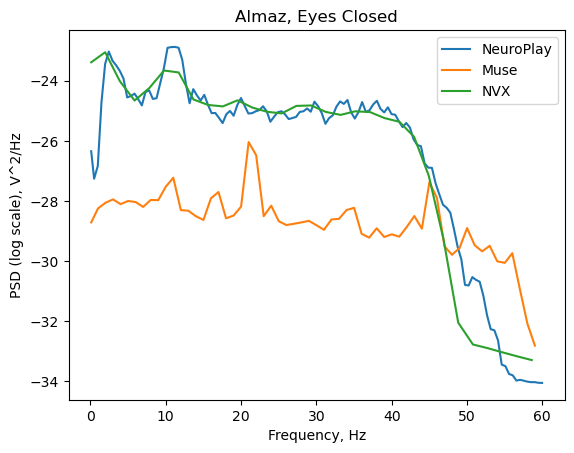

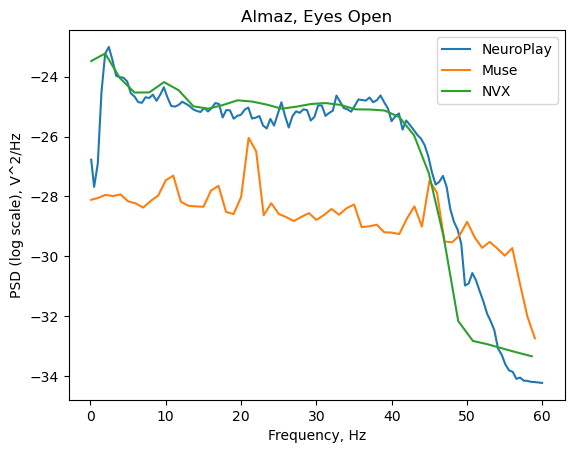

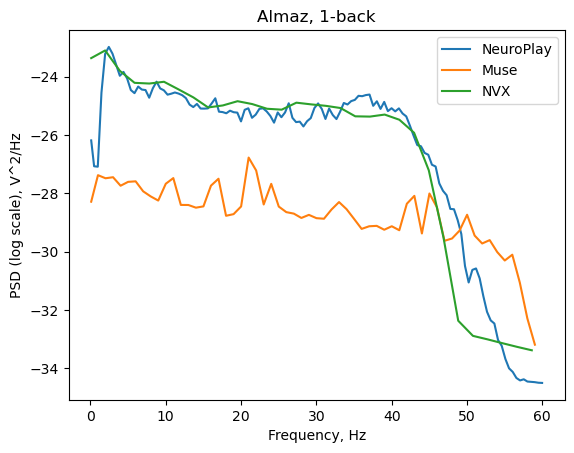

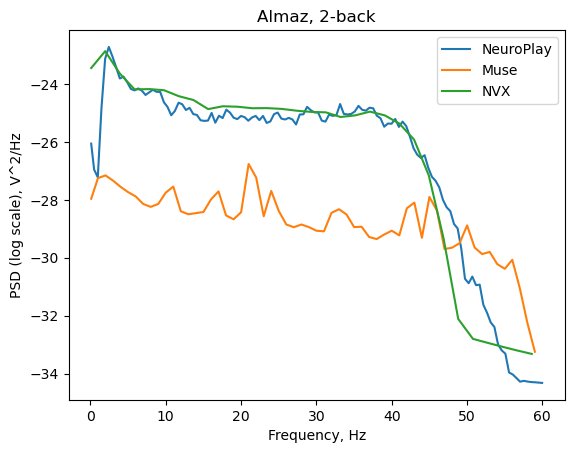

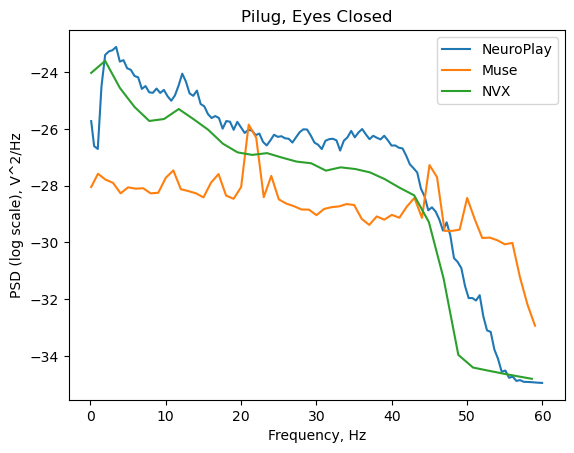

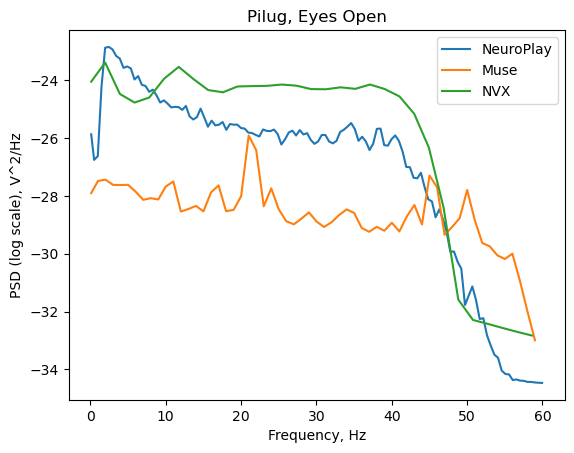

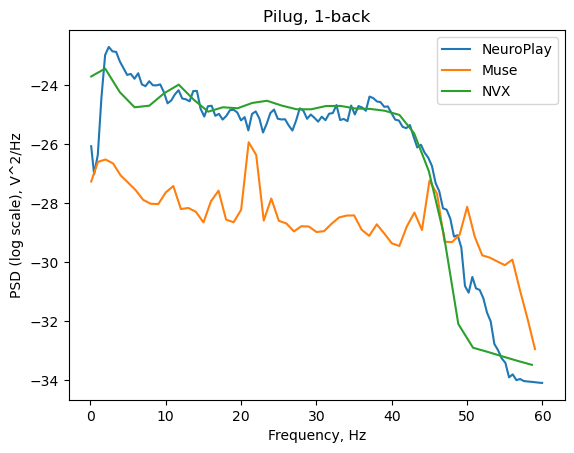

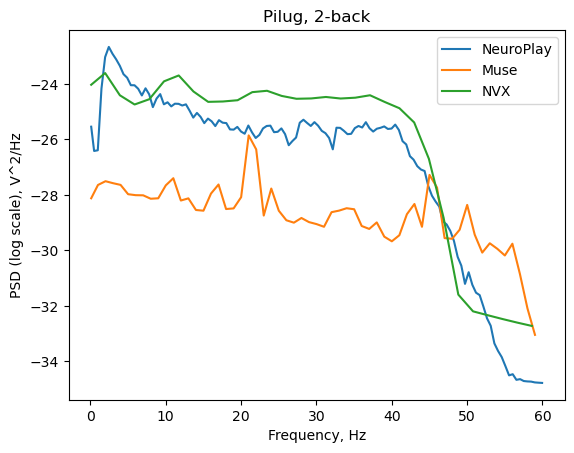

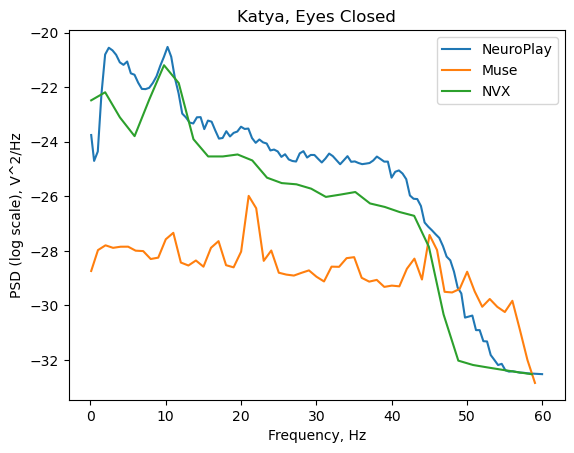

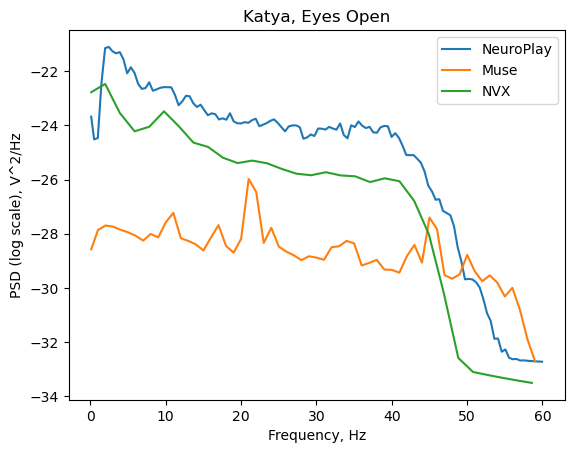

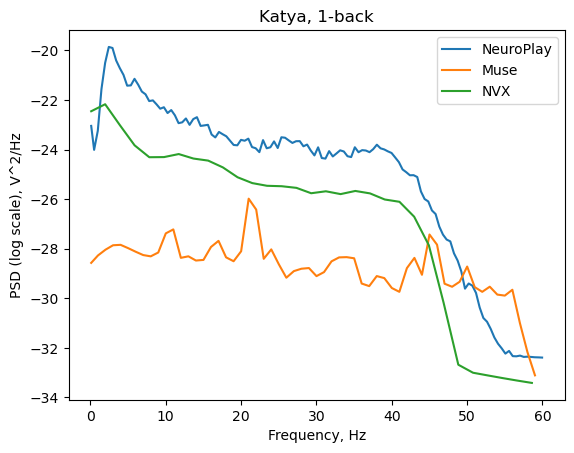

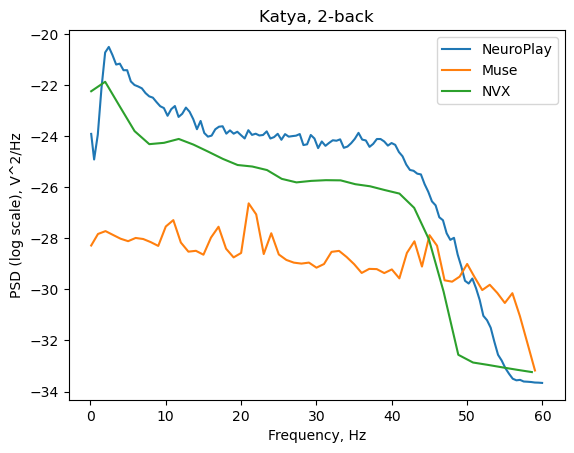

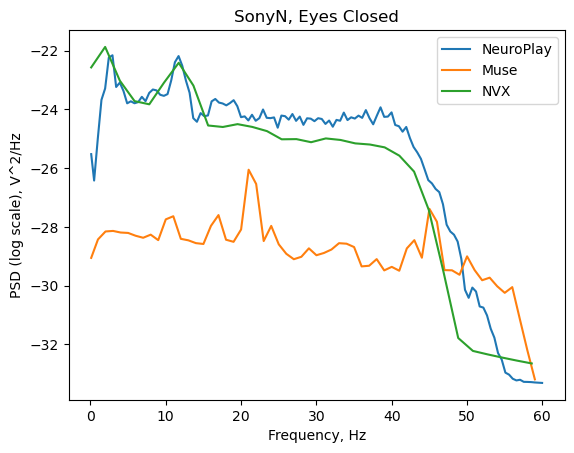

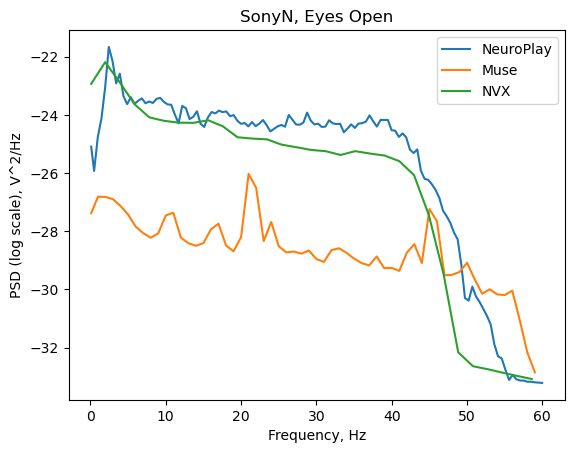

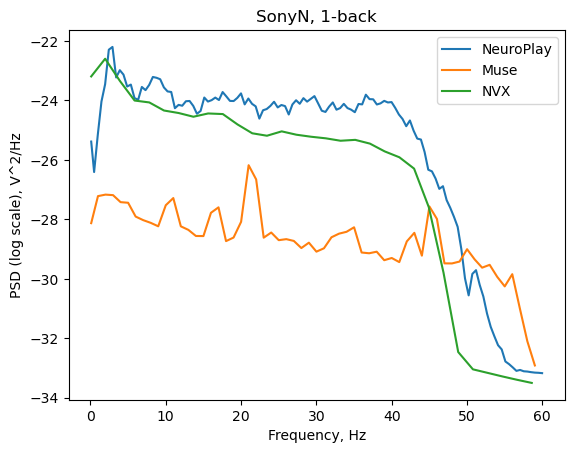

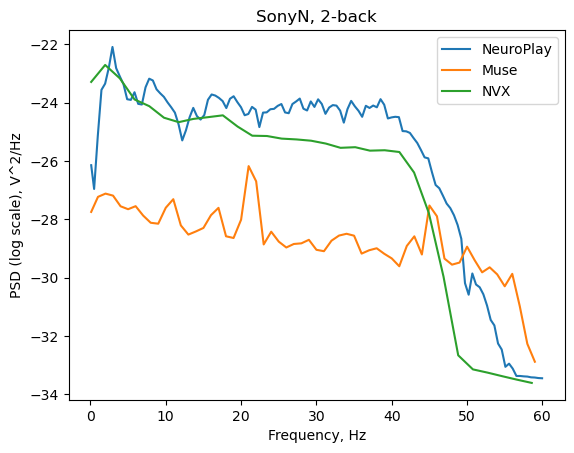

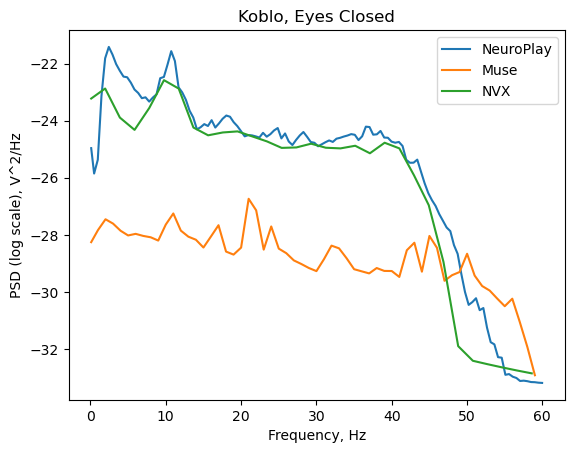

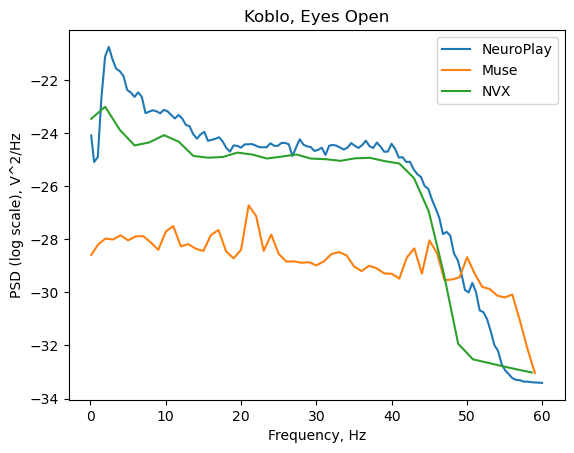

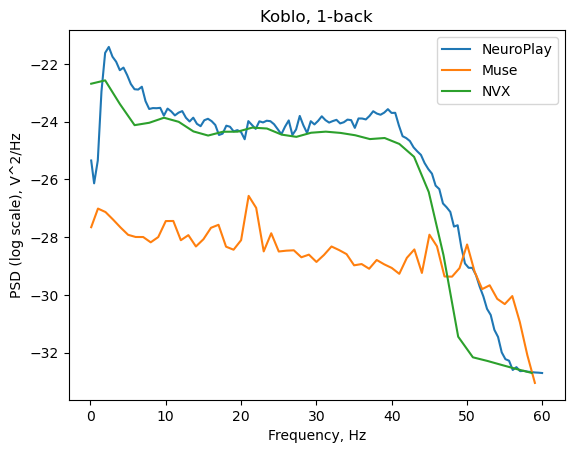

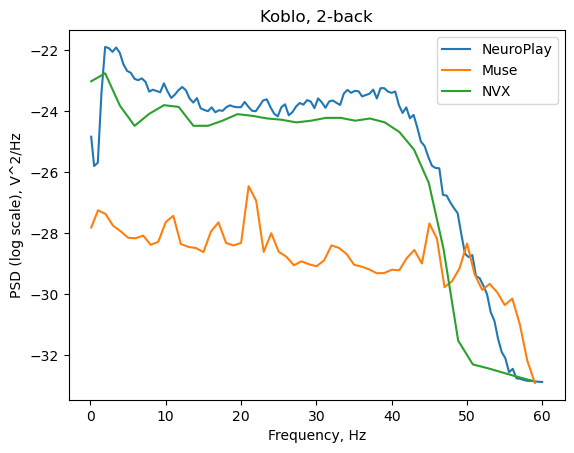

In [39]:
for i in fiveletters:
    if (i != 'Alice') and (i != 'Medve'):
        for j in ['_ec', '_eo', '_1b', '_2b']:
            plt.figure()
            plt.plot(dict5l[i][i+'_neu'+j][0],dict5l[i][i+'_neu'+j][1],label='NeuroPlay') 
            plt.plot(dict5l[i][i+'_mus'+j][0],dict5l[i][i+'_mus'+j][1],label='Muse')
            plt.plot(dict5l[i][i+'_nvx'+j][0],dict5l[i][i+'_nvx'+j][1],label='NVX')
            plt.xlabel('Frequency, Hz')
            plt.ylabel('PSD (log scale), V^2/Hz')
            if j == "_ec":
                forTit = 'Eyes Closed'
            if j == "_eo":
                forTit = 'Eyes Open' 
            if j == "_1b":
                forTit = '1-back'
            if j == "_2b":
                forTit = '2-back'
            plt.title(i + ', ' + forTit)
            plt.legend()
            #plt.show()
            plt.savefig('C:\\Users\\Lenovo\\1easyEEG\\psdEveryPersonEveryCondition\\'+i + '_'+forTit+'.png')

        

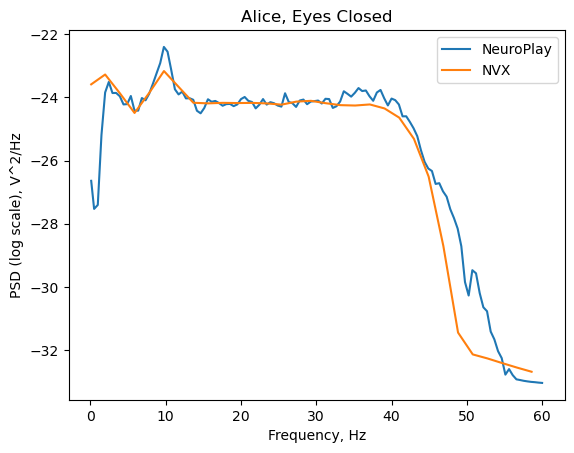

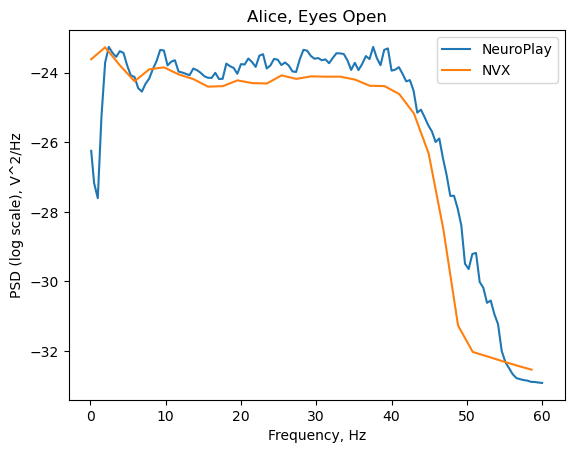

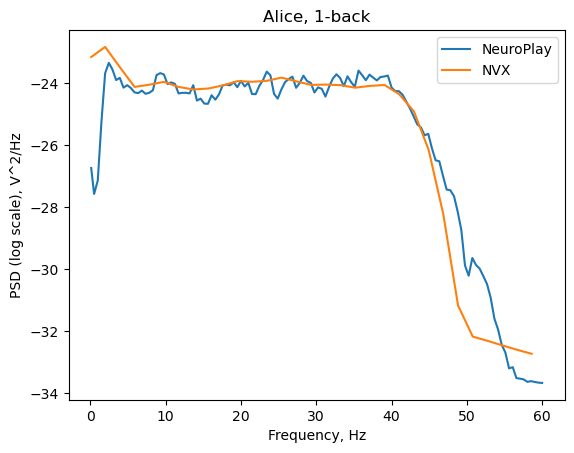

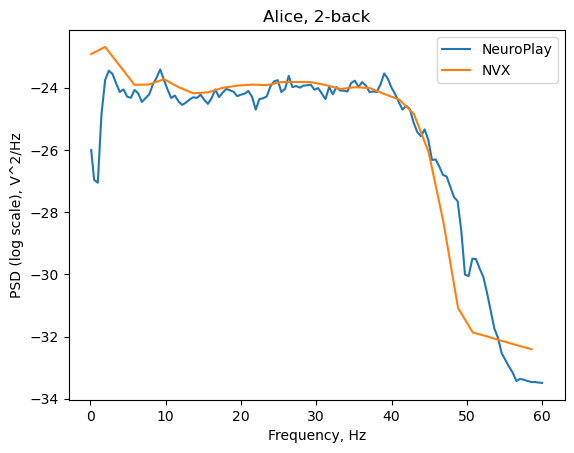

In [40]:
i = 'Alice'
if True:
    if True:
        for j in ['_ec', '_eo', '_1b', '_2b']:
            plt.figure()
            plt.plot(dict5l[i][i+'_neu'+j][0],dict5l[i][i+'_neu'+j][1],label='NeuroPlay') 
            plt.plot(dict5l[i][i+'_nvx'+j][0],dict5l[i][i+'_nvx'+j][1],label='NVX')
            plt.xlabel('Frequency, Hz')
            plt.ylabel('PSD (log scale), V^2/Hz')
            if j == "_ec":
                forTit = 'Eyes Closed'
            if j == "_eo":
                forTit = 'Eyes Open' 
            if j == "_1b":
                forTit = '1-back'
            if j == "_2b":
                forTit = '2-back'
            plt.title(i + ', ' + forTit)
            plt.legend()
            #plt.show()
            plt.savefig('C:\\Users\\Lenovo\\1easyEEG\\psdEveryPersonEveryCondition\\'+i + '_'+forTit+'.png')


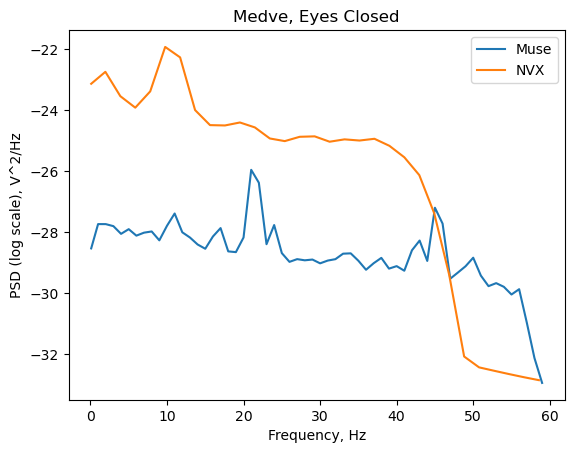

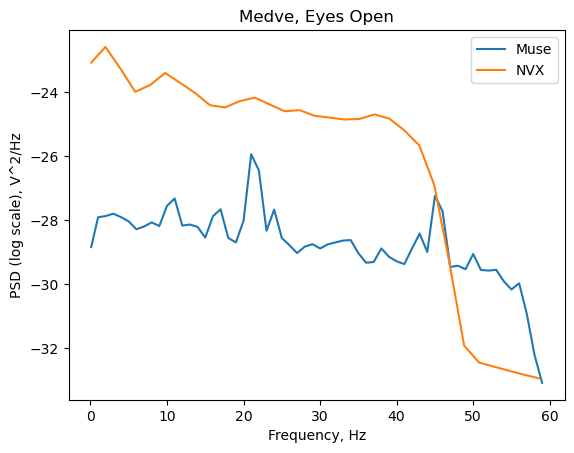

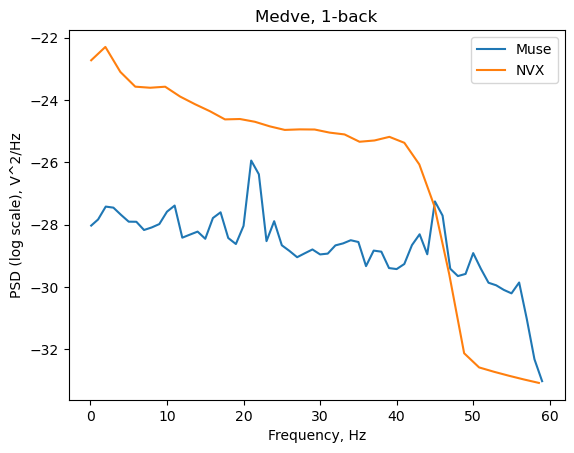

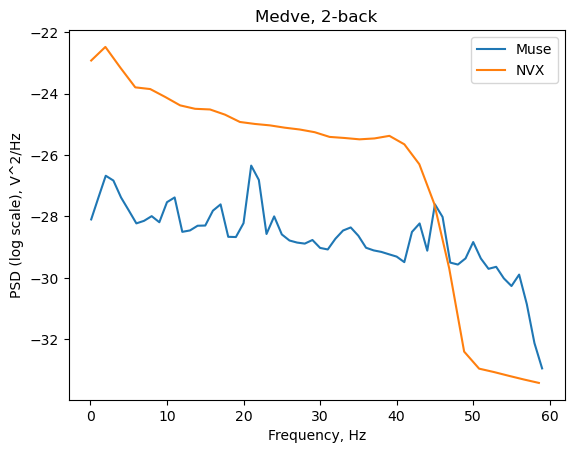

In [41]:
i = 'Medve'
if True:
    if True:
        for j in ['_ec', '_eo', '_1b', '_2b']:
            plt.figure()
            plt.plot(dict5l[i][i+'_mus'+j][0],dict5l[i][i+'_mus'+j][1],label='Muse')
            plt.plot(dict5l[i][i+'_nvx'+j][0],dict5l[i][i+'_nvx'+j][1],label='NVX')
            plt.xlabel('Frequency, Hz')
            plt.ylabel('PSD (log scale), V^2/Hz')
            if j == "_ec":
                forTit = 'Eyes Closed'
            if j == "_eo":
                forTit = 'Eyes Open' 
            if j == "_1b":
                forTit = '1-back'
            if j == "_2b":
                forTit = '2-back'
            plt.title(i + ', ' + forTit)
            plt.legend()
            #plt.show()
            plt.savefig('C:\\Users\\Lenovo\\1easyEEG\\psdEveryPersonEveryCondition\\'+i + '_'+forTit+'.png')


### Черновик для отрисовки псд

Effective window size : 2.051 (s)
Effective window size : 0.512 (s)


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


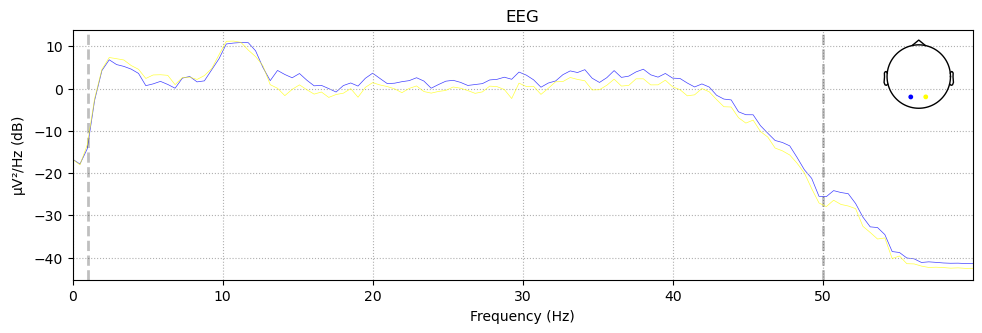

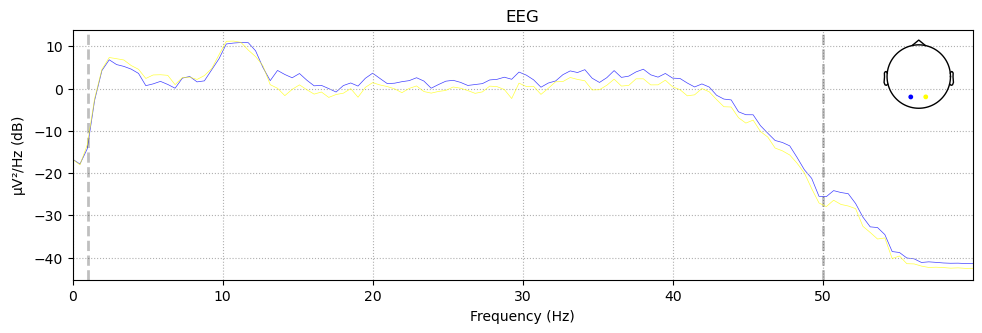

In [46]:
psd_ecl_1 = raw_ec_1.compute_psd(picks=['O1','O2'], fmin=0, fmax=60)
psd_ecl_2 = raw_ec_2.compute_psd(picks=['O1','O2'], fmin=0, fmax=60)
psd_ecl_1.plot()


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


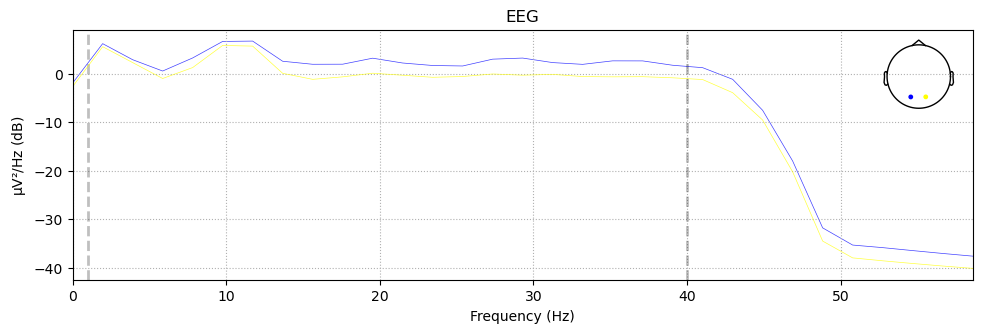

In [10]:
psd_ecl_2.plot()

это разные каналы

In [57]:
#plt.plot(psd_ecl_1[0][0])

In [58]:
#plt.plot(psd_ecl_1[1][0])

##### все вместе

Effective window size : 2.051 (s)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13040\3512915219.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  n = (yy_ec[i] ** 2) / x_ec[i]


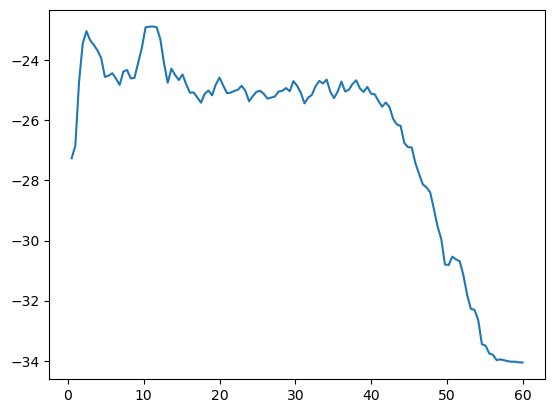

In [139]:
psd_ecl = raw_ec_1.compute_psd(picks=['O1'], fmin=0, fmax=60)
psd_ecl = psd_ecl.get_data(return_freqs=True)
yy_ec = psd_ecl[0][0]
x_ec = psd_ecl[1]
y_ec = []
for i in range(len(yy_ec)):
    n = (yy_ec[i] ** 2) / x_ec[i]
    n = math.log(n,10)
    y_ec.append(n)
plt.plot(x_ec,y_ec)

ок

In [59]:
psd_ecl_1 = psd_ecl_1.get_data(return_freqs=True)
psd_ecl_2 = psd_ecl_2.get_data(return_freqs=True)

In [60]:
psd_ecl_1

(array([[2.12097505e-14, 1.63234704e-14, 3.76182851e-14, 5.24936204e-13,
         2.66180760e-12, 4.77468533e-12, 3.68322488e-12, 3.33245839e-12,
         2.87283999e-12, 2.27589505e-12, 1.16705818e-12, 1.28635189e-12,
         1.47504901e-12, 1.24614999e-12, 1.01512905e-12, 1.76104440e-12,
         1.92298754e-12, 1.43360773e-12, 1.51536610e-12, 2.76632390e-12,
         5.04114939e-12, 1.13014528e-11, 1.18875962e-11, 1.22359738e-11,
         1.21226975e-11, 7.79545920e-12, 3.15918706e-12, 1.53313544e-12,
         2.67629036e-12, 2.14308898e-12, 1.79305491e-12, 2.26275255e-12,
         1.57408642e-12, 1.15775360e-12, 1.18472981e-12, 9.95271873e-13,
         8.25861209e-13, 1.17566796e-12, 1.35199672e-12, 1.14114762e-12,
         1.74334655e-12, 2.30478088e-12, 1.72640754e-12, 1.30514707e-12,
         1.33573277e-12, 1.44975397e-12, 1.53598911e-12, 1.79874571e-12,
         1.50150355e-12, 1.01624172e-12, 1.24185785e-12, 1.48923130e-12,
         1.56376717e-12, 1.39816940e-12, 1.18061271

In [ ]:
psd_ecl_2[1]

In [61]:
#kk = psd_ecl_1[1]
#kk[0]

In [64]:
psd_ecl_1[1]

array([ 0.        ,  0.48752004,  0.97504008,  1.46256012,  1.95008016,
        2.4376002 ,  2.92512023,  3.41264027,  3.90016031,  4.38768035,
        4.87520039,  5.36272043,  5.85024047,  6.33776051,  6.82528055,
        7.31280059,  7.80032063,  8.28784066,  8.7753607 ,  9.26288074,
        9.75040078, 10.23792082, 10.72544086, 11.2129609 , 11.70048094,
       12.18800098, 12.67552102, 13.16304106, 13.65056109, 14.13808113,
       14.62560117, 15.11312121, 15.60064125, 16.08816129, 16.57568133,
       17.06320137, 17.55072141, 18.03824145, 18.52576149, 19.01328152,
       19.50080156, 19.9883216 , 20.47584164, 20.96336168, 21.45088172,
       21.93840176, 22.4259218 , 22.91344184, 23.40096188, 23.88848191,
       24.37600195, 24.86352199, 25.35104203, 25.83856207, 26.32608211,
       26.81360215, 27.30112219, 27.78864223, 28.27616227, 28.76368231,
       29.25120234, 29.73872238, 30.22624242, 30.71376246, 31.2012825 ,
       31.68880254, 32.17632258, 32.66384262, 33.15136266, 33.63

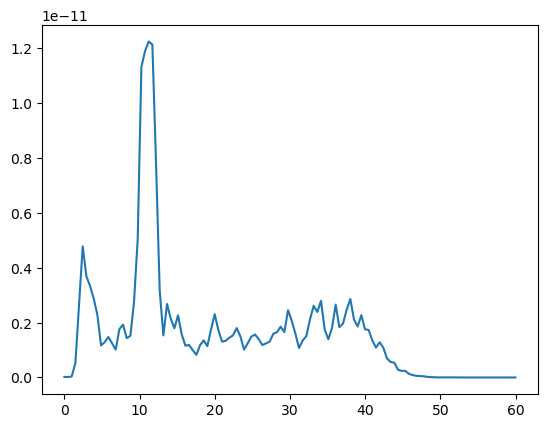

In [68]:
plt.plot(psd_ecl_1[1], psd_ecl_1[0][0])

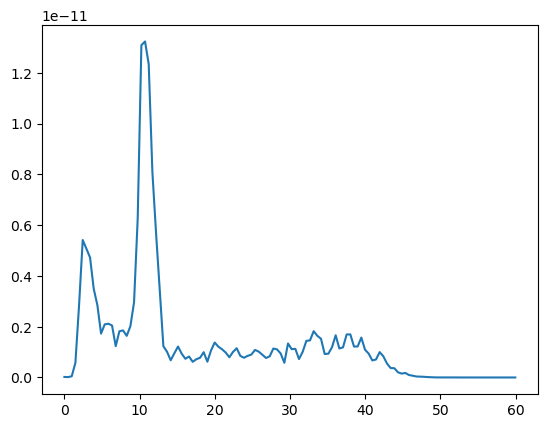

In [105]:
plt.plot(psd_ecl_1[1], psd_ecl_1[0][1])

In [82]:
psd_ecl_1[0][0][7] ** 2

1.110527895227523e-23

In [84]:
import math

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13040\2207657780.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  n = (psd_ecl_1[0][1][i] ** 2) / psd_ecl_1[1][i]


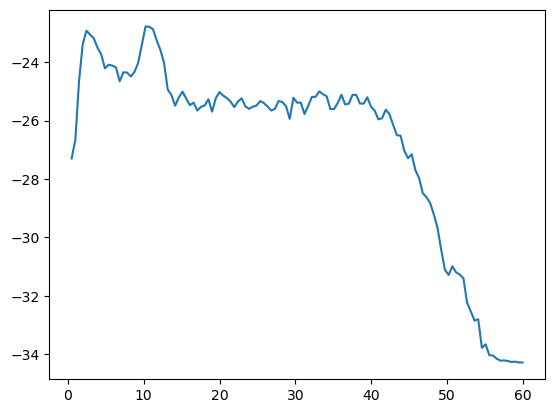

In [107]:
new1 = []
for i in range(len(psd_ecl_1[1])):
    n = (psd_ecl_1[0][1][i] ** 2) / psd_ecl_1[1][i]
    n = math.log(n,10)
    new1.append(n)
plt.plot(psd_ecl_1[1],new1)

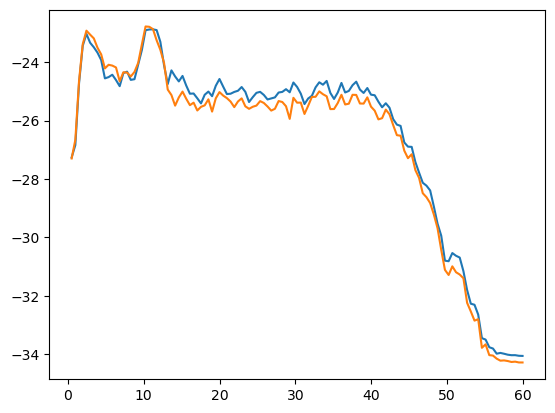

In [112]:
plt.plot(psd_ecl_1[1],new)
plt.plot(psd_ecl_1[1],new1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13040\1523552341.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  n = (psd_ecl_1[0][0][i] ** 2) / psd_ecl_1[1][i]


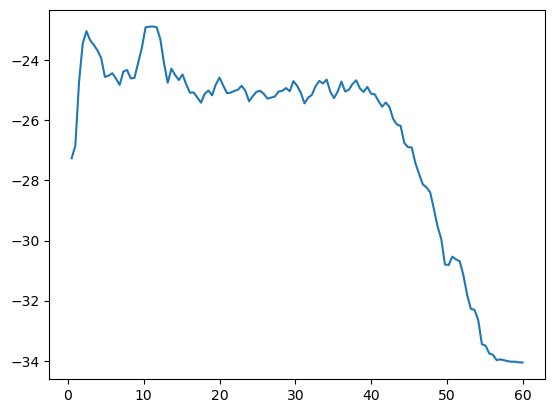

In [110]:
new = []
for i in range(len(psd_ecl_1[1])):
    n = (psd_ecl_1[0][0][i] ** 2) / psd_ecl_1[1][i]
    n = math.log(n,10)
    new.append(n)
plt.plot(psd_ecl_1[1],new)

тут амплитуда а нам нужна мощность ампл

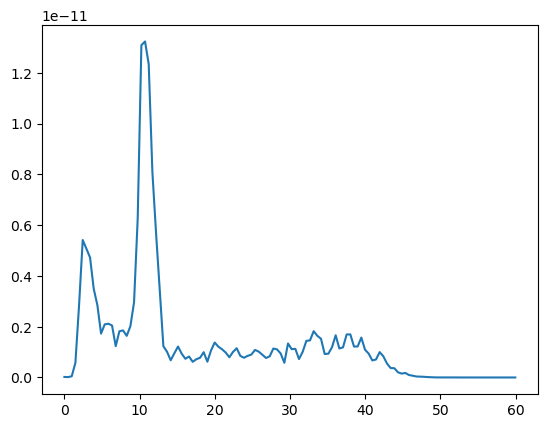

In [23]:
%matplotlib inline
plt.plot(psd_ecl_1[1], psd_ecl_1[0][1])

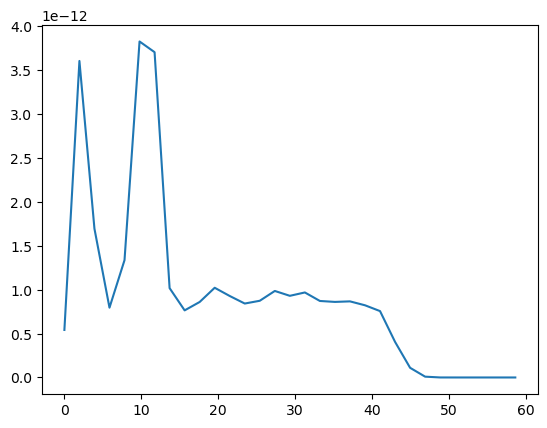

In [24]:
%matplotlib inline
plt.plot(psd_ecl_2[1], psd_ecl_2[0][1])